In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
# Prepare data

piave_data = pd.read_pickle('data\LVDT_20\clean_piave_data.pkl')
sensore = piave_data['LVDT_20']


#labels = ((sensore > np.percentile(sensore,97)) | (sensore < np.percentile(sensore,3))).astype(int)
#labels.value_counts()


In [3]:
def random_offset_damage(sensor, param, num_segments=3, segment_length=24*7):
    """
    Adds an offset to random time periods in the sensor data based on the specified damage intensity.

    Args:
        sensor (pd.Series): Sensor data to be modified.
        param (float): Intensity of the damage, as a proportion of the sensor's range.
        num_segments (int): Number of damaged segments to introduce.
        segment_length (int): Length of each damaged segment.

    Returns:
        pd.Series: Sensor data with local damage applied to time periods.
    """
    random.seed(10)
    # Calculate the range (delta) of the sensor values
    delta = sensor.max() - sensor.min()
    
    # Determine the damage offset
    damage = delta * param

    # Create a copy of the sensor data to avoid modifying the original
    damaged_sensor = sensor.copy()
    damage_mask = np.zeros(len(sensor), dtype= int)

    # Get the length of the sensor data
    n = len(sensor)

    # Apply damage to random segments
    for _ in range(num_segments):
        # Select a random start index for the segment
        start_idx = np.random.randint(0, max(1, n - segment_length))
        
        # Define the end index
        end_idx = min(start_idx + segment_length, n)
        
        # Apply the same damage to the whole segment
        damaged_sensor.iloc[start_idx:end_idx] += damage
        damage_mask[start_idx:end_idx] = 1
    
    damage_mask = pd.Series(damage_mask, index = damaged_sensor.index)


    return damaged_sensor, damage_mask



In [19]:
split_idx = int(len(sensore) * 0.8)

train_data, train_labels = sensore[:split_idx], pd.Series(0,index = sensore[:split_idx].index)
test_data, test_labels = random_offset_damage(sensore[split_idx:], 0.2, 10 )


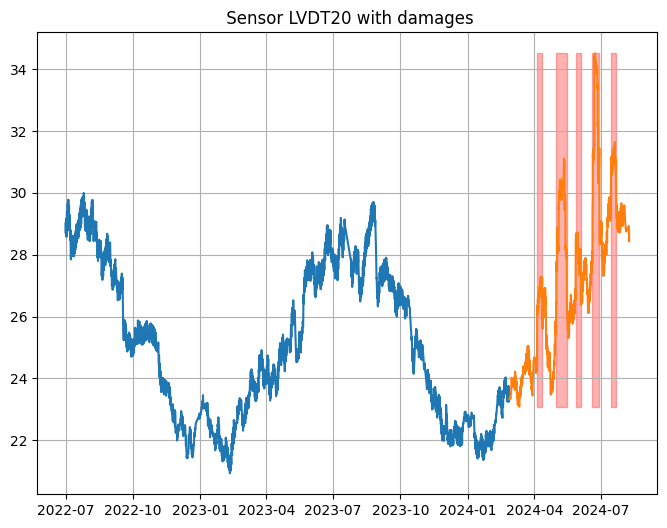

In [20]:
# Plot 

plt.figure(figsize=(8,6))
plt.plot(train_data, label = 'train data')
plt.plot(test_data, label = 'test_data')
plt.fill_between(train_data.index,train_data.min(), train_data.max(), where=train_labels==1, color='red', alpha=0.3, label="Damage Regions")
plt.fill_between(test_data.index,test_data.min(), test_data.max(), where=test_labels==1, color='red', alpha=0.3, label="Damage Regions")

plt.grid()
plt.title(' Sensor LVDT20 with damages')

plt.show()

In [21]:
# Save data in .csv
train = pd.concat([train_data, train_labels],axis = 1)
train.columns = ['value', 'anomaly']
train.to_csv('data/LVDT_20/train_data.csv', index = False)

test = pd.concat([test_data, test_labels],axis = 1)
test.columns = ['value', 'anomaly']
test.to_csv('data/LVDT_20/test_data.csv', index = False)

In [22]:
check = pd.read_csv('data/LVDT_20/test_data.csv')
np.unique(check['anomaly'].values, return_counts= True)


(array([0, 1], dtype=int64), array([2445,  965], dtype=int64))